# Simulating the effect of pixelization errors on Gaussian fittings

## Importing packages

In [17]:
import os
import sys
sys.path.append('./')

import math
import numpy as np
from numpy import size
from scipy.optimize import curve_fit
from astropy.table import Table, Column

import matplotlib
#matplotlib.use('PDF')
import matplotlib.pyplot as plt
%matplotlib inline

## Defining functions and classes

In [18]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [19]:
# parent class
class spectrum:
    'Parent class for a spectrum \n \
     Attributes \n \
     num_components ( int ) : counters for total number of spectra \n \
    '
    num_components = 0
    
    def __init__(self):
        spectrum.num_components += 1
    
    def __del__(self):
        spectrum.num_components -= 1
    

    
# subclasses
class gaussian_spectrum( spectrum ):
    'Sub-class of spectrum. Gaussian profile \n \
     constructed by, e.g., spectrum1 = gaussian_spectrum() \n\n \
     Attributes: \n \
     A (float) : Amplitude of the gaussian spectrum \n \
     sigma (float) : standard deviation [bins] of the gaussian spectrum \n \
     bins (int) : number of bins to sample the spectrum. \n \
     data (numpy array) : the stored intensity values \n \
     resampleddata (numpy array) : the stored, resampled intensity values \n \
     '

    num_components = 0

    def __init__(self, name = 'gaussian_unknown', 
               A=1.0, sigma=1.0, bins=256):
        spectrum.num_components += 1
        gaussian_spectrum.num_components += 1
        self.name  = name
        self.A = A
        self.sigma = sigma
        self.bins  = bins
        self.x     = np.arange(0, bins)
        self.center = float(bins - 1) / 2.0

        self.data = \
        A * np.exp( - ( self.x - self.center)**2.0 / (2.0 * sigma**2) )
        self.resampleddata = self.data
    # print( self.name )
    # print( self.data )
    
    def __del__(self):
        spectrum.num_components -= 1
        gaussian_spectrum.num_components -= 1

    def resample(self, pixelsize=20, pixelshift=10):
    # pixelsize: pixelsize in units of bin
    # pixelshift: In unit of bin. A parameter to shift the resampling pixels with respect to the
    #             original Gaussian spectrum
    
        for i in range(0, pixelshift):
            self.resampleddata[i] = np.sum( self.data[0:pixelshift] ) / pixelsize

        resampled_bins = int( 
            ( self.bins - pixelshift ) / pixelsize
        )
        for i in range(0, resampled_bins):
            for j  in range(0, pixelsize):
                k = pixelshift + pixelsize * i + j
                start = pixelshift + pixelsize * i
                end   = pixelshift + pixelsize * (i+1)
                self.resampleddata[k] = np.sum( self.data[start:end] ) / pixelsize
        
    def add_noise(self, RMS=0.1):
    # RMS: the RMS noise level
        noise = np.random.normal(0.0, RMS, self.bins)
        self.data = self.data + noise
    
    def refit_gaussian(self):
        p0 = [1., self.bins/2.0, 1.]
        coeff, var_matrix = curve_fit(gauss, self.x, self.resampleddata, p0=p0)
        return coeff
    

## Printing help files

In [36]:
print ( 'spectrum :\n', spectrum.__doc__ )
print ( 'gaussian_spectrum :\n', gaussian_spectrum.__doc__ )

spectrum :
 Parent class for a spectrum 
      Attributes 
      num_components ( int ) : counters for total number of spectra 
   
gaussian_spectrum :
 Sub-class of spectrum. Gaussian profile 
      constructed by, e.g., spectrum1 = gaussian_spectrum() 

    Attributes: 
    A (float) : Amplitude of the gaussian spectrum 
    sigma (float) : standard deviation [bins] of the gaussian spectrum 
    bins (int) : number of bins to sample the spectrum. 
    data (numpy array) : the stored intensity values 
    resampleddata (numpy array) : the stored, resampled intensity values 
   


## Plotting results

In [43]:
Target = 'imfit_finial_results_addradec_sortflux_table_pbflux_mass_Mach_seperatemass_area_extP.fits'
T = Table.read(Target, hdu=3)
Mgas = T['Mass']
Dreff = T['decr_eff']
Asig = T['fitted_Asigma']
T[43]
#T.show_in_browser()

index,newindex,peak,flux,pbflux,major,minor,pa,RA,DEC,r_eff,decr_eff,Mass,decmajor,decminor,decpa,erdecmaj,erdecmin,separation,RApix,DECpix,fitted_Asigma,fitted_Bsigma,fitted_Csigma,fitted_Dsigma,A_Mach,B_Mach,C_Mach,n_vol,A_Mass,A_Mvir,A_vir,A_sigma,A_decr,B_Mass,B_Mvir,B_vir,B_sigma,B_decr,C_Mass,C_Mvir,C_vir,C_sigma,C_decr,A_nvol,B_nvol,C_nvol,B_A,A_Pek,B_Pek,C_Pek,AOmega_P,AOmega_G,AOmega_K,AOmega_F,BOmega_P,BOmega_G,BOmega_K,BOmega_F,COmega_P,COmega_G,COmega_K,COmega_F
,,Jy beam$^{-1}$,Jy,Jy,arcsec,arcsec,deg,deg,deg,arcsec,arcsec,M$_{\odot}$,arcsec,arcsec,deg,arcsec,arcsec,pc,pix,pix,km / s,km / s,km / s,km / s,,,,cm$^{-3}$,M$_{\odot}$,M$_{\odot}$,,,pc,M$_{\odot}$,M$_{\odot}$,,,pc,M$_{\odot}$,M$_{\odot}$,,,pc,cm$^{-3}$,cm$^{-3}$,cm$^{-3}$,mG,K cm$^{-3}$,K cm$^{-3}$,K cm$^{-3}$,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
32,43,0.00028465746570476903,0.0004743388650384431,0.0004884172221464821,4.85861303970988,2.923623141513633,96.21971826167152,259.77270361032186,-36.119027758425574,2.2634667800892485,1.3196125340786613,0.27323149419644366,3.389364603918985,1.4244920394450384,108.38519755674173,0.72,0.93,0.06021436590272268,620.76,750.36,0.3264,nan,nan,nan,1.284922,nan,nan,2184083.626057515,0.27323149419644366,1.4697234751629764,5.379041239317375,0.389884,0.008316952921253049,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2184083.626057515,nan,nan,nan,19939501.409274407,nan,nan,-5.847417499881651e+41,-7.679051444971798e+41,1.2391606830754979e+42,-5.77455114424339e+40,nan,nan,nan,nan,nan,nan,nan,nan


Assuming cores are virialized 
 --> core 43 parameters: 
sigma 0.23773765463924268 km/s 
FWHM 0.5598293946031337 km/s 
Reff 0.008316952921253047 pc
-----------------------------------
[4.65611114e-02 6.34361073e+01 1.07399439e+00]


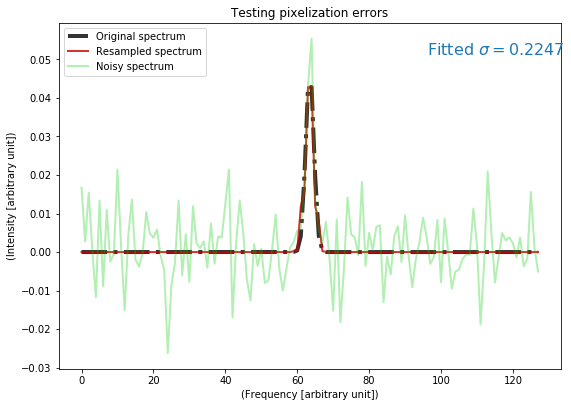

In [33]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
v_delta = 0.21  # km/s

i = 43
print 'Assuming cores are virialized \n \
--> core {} parameters: '.format(i) 
Reff = 1300./206265 * Dreff[i]   # pc
M = Mgas[i]      # Msolar
alpha = 2.0
sigma2fwhm = 2.*np.sqrt(2*np.log(2))

sigma = np.sqrt(alpha * M * G /(5.* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

print '-----------------------------------'


test_spectrum = gaussian_spectrum(name='test', A=0.04719, sigma=sigma/v_delta, bins=128)
A = 0.04719

fig = plt.figure(figsize=(9, 14))
plt.subplot(2, 1, 1)

# plotting the original gaussian spectrum
plt.plot(test_spectrum.x , test_spectrum.data, \
         '-.',
         color = (0, 0, 0.0, 0.8),
         linewidth=4, label = 'Original spectrum')    

# resampling
test_spectrum.resample(pixelsize=2, pixelshift=7)
plt.plot(test_spectrum.x , test_spectrum.resampleddata, \
         color = (0.8, 0.0, 0.0, 0.8),
         linewidth=2, label = 'Resampled spectrum')    

# inject noise
test_spectrum.add_noise(RMS=0.008)
plt.plot(test_spectrum.x , test_spectrum.data, \
         color = (0, 0.8, 0.0, 0.3),
         linewidth=2, label = 'Noisy spectrum')    

# fit Gaussian and print the results
coeff = test_spectrum.refit_gaussian()
print( coeff )
plt.text( test_spectrum.bins*0.75, coeff[0]*1.1,
         'Fitted $\sigma=$%s' %(str( round( coeff[2], 2)*v_delta ) ), 
         {'color': 'C0', 'fontsize': 16})

spectrum_fit = gauss( test_spectrum.x, *coeff)
#plt.plot(test_spectrum.x, spectrum_fit, label='Fitted Gaussian')

plt.title('Testing pixelization errors')
plt.xlabel( '(Frequency [arbitrary unit])')
plt.ylabel( '(Intensity [arbitrary unit])')
plt.legend(loc=2)
#print 'Fitted $\sigma=$%s' %(str( round( coeff[2], 2) ) )

Assuming cores are virialized 
 --> core 43 parameters: 
sigma 0.23773765463924268 km/s 
FWHM 0.5598293946031337 km/s 
Reff 0.008316952921253047 pc
-----------------------------------
[4.89803426e-02 1.27781999e+02 1.12610174e+00]


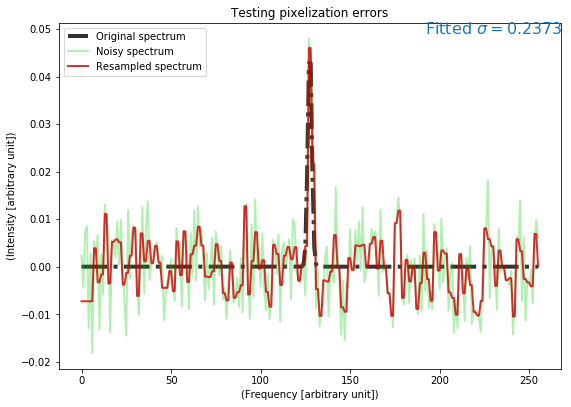

In [35]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
v_delta = 0.21  # km/s

i = 43
print 'Assuming cores are virialized \n \
--> core {} parameters: '.format(i) 
Reff = 1300./206265 * Dreff[i]   # pc
M = Mgas[i]      # Msolar
alpha = 2.0
sigma2fwhm = 2.*np.sqrt(2*np.log(2))

sigma = np.sqrt(alpha * M * G /(5.* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

print '-----------------------------------'


test_spectrum = gaussian_spectrum(name='test', A=0.04719, sigma=sigma/v_delta, bins=256)
A = 0.04719

fig = plt.figure(figsize=(9, 14))
plt.subplot(2, 1, 1)

# plotting the original gaussian spectrum
plt.plot(test_spectrum.x , test_spectrum.data, \
         '-.',
         color = (0, 0, 0.0, 0.8),
         linewidth=4, label = 'Original spectrum')    

# inject noise
test_spectrum.add_noise(RMS=0.008)
plt.plot(test_spectrum.x , test_spectrum.data, \
         color = (0, 0.8, 0.0, 0.3),
         linewidth=2, label = 'Noisy spectrum')    

# resampling
test_spectrum.resample(pixelsize=2, pixelshift=7)
plt.plot(test_spectrum.x , test_spectrum.resampleddata, \
         color = (0.8, 0.0, 0.0, 0.8),
         linewidth=2, label = 'Resampled spectrum')    


# fit Gaussian and print the results
coeff = test_spectrum.refit_gaussian()
print( coeff )
plt.text( test_spectrum.bins*0.75, coeff[0]*1.,
         'Fitted $\sigma=$%s' %(str( round( coeff[2], 2)*v_delta ) ), 
         {'color': 'C0', 'fontsize': 16})

spectrum_fit = gauss( test_spectrum.x, *coeff)
#plt.plot(test_spectrum.x, spectrum_fit, label='Fitted Gaussian')

plt.title('Testing pixelization errors')
plt.xlabel( '(Frequency [arbitrary unit])')
plt.ylabel( '(Intensity [arbitrary unit])')
plt.legend(loc=2)
#print 'Fitted $\sigma=$%s' %(str( round( coeff[2], 2) ) )

In [21]:
T[42]

index,newindex,peak,flux,pbflux,major,minor,pa,RA,DEC,r_eff,decr_eff,Mass,decmajor,decminor,decpa,erdecmaj,erdecmin,separation,RApix,DECpix,fitted_Asigma,fitted_Bsigma,fitted_Csigma,fitted_Dsigma,A_Mach,B_Mach,C_Mach,n_vol,A_Mass,A_Mvir,A_vir,A_sigma,A_decr,B_Mass,B_Mvir,B_vir,B_sigma,B_decr,C_Mass,C_Mvir,C_vir,C_sigma,C_decr,A_nvol,B_nvol,C_nvol,B_A,A_Pek,B_Pek,C_Pek,AOmega_P,AOmega_G,AOmega_K,AOmega_F,BOmega_P,BOmega_G,BOmega_K,BOmega_F,COmega_P,COmega_G,COmega_K,COmega_F
,,Jy beam$^{-1}$,Jy,Jy,arcsec,arcsec,deg,deg,deg,arcsec,arcsec,M$_{\odot}$,arcsec,arcsec,deg,arcsec,arcsec,pc,pix,pix,km / s,km / s,km / s,km / s,,,,cm$^{-3}$,M$_{\odot}$,M$_{\odot}$,,,pc,M$_{\odot}$,M$_{\odot}$,,,pc,M$_{\odot}$,M$_{\odot}$,,,pc,cm$^{-3}$,cm$^{-3}$,cm$^{-3}$,mG,K cm$^{-3}$,K cm$^{-3}$,K cm$^{-3}$,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
26,42,0.00024297109820233098,0.0005215684492535282,0.0006205839143517507,4.9704637554559845,3.68152179622921,149.8338714512868,259.75272002920576,-36.12144337303961,2.5690314295987573,1.263840834449661,0.5930539136286738,4.308828768649598,1.0278056082636446,158.12461377111615,1.6,2.4,0.06439677522555373,755.9,730.1,0.21776180745922705,nan,nan,nan,0.8245005637992996,nan,nan,5396284.376071799,0.5930539136286738,0.8114381646785375,1.3682367589712925,0.2960208743110064,0.007965447772450776,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5396284.376071799,nan,nan,nan,47183028.270774834,nan,nan,-1.2155518076717702e+42,-3.7773607561505166e+42,1.5504754439870887e+42,-5.07289748459805e+40,nan,nan,nan,nan,nan,nan,nan,nan


Assuming cores are virialized 
 --> core 42 parameters: 
sigma 0.35789588733817873 km/s 
FWHM 0.8427804095380816 km/s 
Reff 0.007965447772450776 pc
-----------------------------------
[4.46269167e-02 6.33762557e+01 1.79849351e+00]


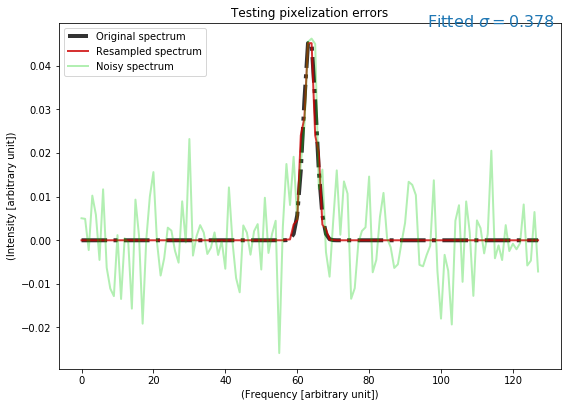

In [36]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
v_delta = 0.21  # km/s

i = 42
print 'Assuming cores are virialized \n \
--> core {} parameters: '.format(i) 
Reff = 1300./206265 * Dreff[i]   # pc
M = Mgas[i]      # Msolar
sigma2fwhm = 2.*np.sqrt(2*np.log(2))

sigma = np.sqrt(alpha * M * G /(5.* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

print '-----------------------------------'

A = 0.04719
test_spectrum = gaussian_spectrum(name='test', A=A, sigma=sigma/v_delta, bins=128)

fig = plt.figure(figsize=(9, 14))
plt.subplot(2, 1, 1)

# plotting the original gaussian spectrum
plt.plot(test_spectrum.x , test_spectrum.data, \
         '-.',
         color = (0, 0, 0.0, 0.8),
         linewidth=4, label = 'Original spectrum')    

# resampling
test_spectrum.resample(pixelsize=2, pixelshift=7)
plt.plot(test_spectrum.x , test_spectrum.resampleddata, \
         color = (0.8, 0.0, 0.0, 0.8),
         linewidth=2, label = 'Resampled spectrum')    

# inject noise
test_spectrum.add_noise(RMS=0.008)
plt.plot(test_spectrum.x , test_spectrum.data, \
         color = (0, 0.8, 0.0, 0.3),
         linewidth=2, label = 'Noisy spectrum')    

# fit Gaussian and print the results
coeff = test_spectrum.refit_gaussian()
print( coeff )
plt.text( test_spectrum.bins*0.75, coeff[0]*1.1,
         'Fitted $\sigma=$%s' %(str( round( coeff[2], 2)*v_delta ) ), 
         {'color': 'C0', 'fontsize': 16})

spectrum_fit = gauss( test_spectrum.x, *coeff)
#plt.plot(test_spectrum.x, spectrum_fit, label='Fitted Gaussian')

plt.title('Testing pixelization errors')
plt.xlabel( '(Frequency [arbitrary unit])')
plt.ylabel( '(Intensity [arbitrary unit])')
plt.legend(loc=2)
#print 'Fitted $\sigma=$%s' %(str( round( coeff[2], 2) ) )

In [30]:
T[39]

index,newindex,peak,flux,pbflux,major,minor,pa,RA,DEC,r_eff,decr_eff,Mass,decmajor,decminor,decpa,erdecmaj,erdecmin,separation,RApix,DECpix,fitted_Asigma,fitted_Bsigma,fitted_Csigma,fitted_Dsigma,A_Mach,B_Mach,C_Mach,n_vol,A_Mass,A_Mvir,A_vir,A_sigma,A_decr,B_Mass,B_Mvir,B_vir,B_sigma,B_decr,C_Mass,C_Mvir,C_vir,C_sigma,C_decr,A_nvol,B_nvol,C_nvol,B_A,A_Pek,B_Pek,C_Pek,AOmega_P,AOmega_G,AOmega_K,AOmega_F,BOmega_P,BOmega_G,BOmega_K,BOmega_F,COmega_P,COmega_G,COmega_K,COmega_F
,,Jy beam$^{-1}$,Jy,Jy,arcsec,arcsec,deg,deg,deg,arcsec,arcsec,M$_{\odot}$,arcsec,arcsec,deg,arcsec,arcsec,pc,pix,pix,km / s,km / s,km / s,km / s,,,,cm$^{-3}$,M$_{\odot}$,M$_{\odot}$,,,pc,M$_{\odot}$,M$_{\odot}$,,,pc,M$_{\odot}$,M$_{\odot}$,,,pc,cm$^{-3}$,cm$^{-3}$,cm$^{-3}$,mG,K cm$^{-3}$,K cm$^{-3}$,K cm$^{-3}$,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
34,39,0.0002844653311763688,0.0005427604018674856,0.0005552345686047649,5.706883831695427,2.8500164764403833,88.59789287211036,259.7769727701703,-36.10721280866302,2.422035337978838,1.5683004864589558,0.5301280187173213,4.437674233579335,1.536698222352929,92.02209764158228,0.59,0.34,0.06752820968932315,591.9,849.28,0.2282,0.2081,0.1652,0.1310304862930116,0.8555,0.740239,0.53903138,2524472.99168516,0.3341346237524098,1.0800286840524809,3.232315980677209,0.30658,0.009884326630289398,0.24425846839193507,0.9811497540519707,4.016850512947728,0.294319,0.009743121964142405,0.03316714128483164,0.14663456599934313,4.421079427379039,0.262133,0.0018356606599108883,1591151.2280479162,1214469.0687437775,24658239.210677236,nan,17263916.526210744,12988690.700196838,49686140.505189195,-8.498409848282614e+41,-9.662870932186624e+41,9.369904455927859e+41,-9.69319094233857e+40,-6.123741808434988e+41,-5.238554011915252e+41,6.312658130102437e+41,-9.283674820048687e+40,-1.5666412027054762e+40,-5.126653754561435e+40,1.2262020295510987e+40,-6.20872900883902e+38


Assuming cores are virialized 
 --> core 39 parameters: 
sigma 0.30376067696696435 km/s 
FWHM 0.7153017310139786 km/s 
Reff 0.009884326630289398 pc
-----------------------------------
[4.43297448e-02 6.33857464e+01 1.52158979e+00]


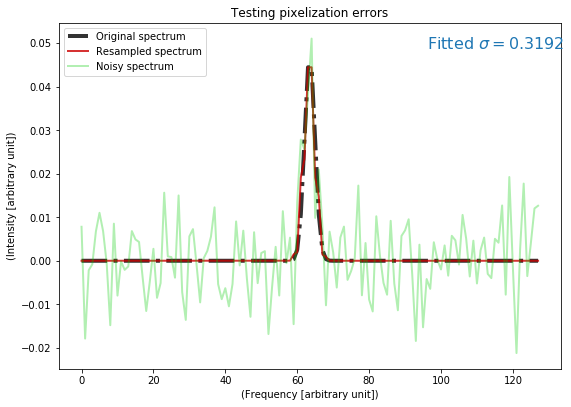

In [37]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
v_delta = 0.21  # km/s

i = 39
print 'Assuming cores are virialized \n \
--> core {} parameters: '.format(i) 
Reff = 1300./206265 * Dreff[i]   # pc
M = Mgas[i]      # Msolar
alpha = 2.0
sigma2fwhm = 2.*np.sqrt(2*np.log(2))

sigma = np.sqrt(alpha * M * G /(5.* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

print '-----------------------------------'

A = 0.04719
test_spectrum = gaussian_spectrum(name='test', A=A, sigma=sigma/v_delta, bins=128)

fig = plt.figure(figsize=(9, 14))
plt.subplot(2, 1, 1)

# plotting the original gaussian spectrum
plt.plot(test_spectrum.x , test_spectrum.data, \
         '-.',
         color = (0, 0, 0.0, 0.8),
         linewidth=4, label = 'Original spectrum')    

# resampling
test_spectrum.resample(pixelsize=2, pixelshift=7)
plt.plot(test_spectrum.x , test_spectrum.resampleddata, \
         color = (0.8, 0.0, 0.0, 0.8),
         linewidth=2, label = 'Resampled spectrum')    

# inject noise
test_spectrum.add_noise(RMS=0.008)
plt.plot(test_spectrum.x , test_spectrum.data, \
         color = (0, 0.8, 0.0, 0.3),
         linewidth=2, label = 'Noisy spectrum')    

# fit Gaussian and print the results
coeff = test_spectrum.refit_gaussian()
print( coeff )
plt.text( test_spectrum.bins*0.75, coeff[0]*1.1,
         'Fitted $\sigma=$%s' %(str( round( coeff[2], 2)*v_delta ) ), 
         {'color': 'C0', 'fontsize': 16})

spectrum_fit = gauss( test_spectrum.x, *coeff)
#plt.plot(test_spectrum.x, spectrum_fit, label='Fitted Gaussian')

plt.title('Testing pixelization errors')
plt.xlabel( '(Frequency [arbitrary unit])')
plt.ylabel( '(Intensity [arbitrary unit])')
plt.legend(loc=2)
#print 'Fitted $\sigma=$%s' %(str( round( coeff[2], 2) ) )

In [38]:
T[38]

index,newindex,peak,flux,pbflux,major,minor,pa,RA,DEC,r_eff,decr_eff,Mass,decmajor,decminor,decpa,erdecmaj,erdecmin,separation,RApix,DECpix,fitted_Asigma,fitted_Bsigma,fitted_Csigma,fitted_Dsigma,A_Mach,B_Mach,C_Mach,n_vol,A_Mass,A_Mvir,A_vir,A_sigma,A_decr,B_Mass,B_Mvir,B_vir,B_sigma,B_decr,C_Mass,C_Mvir,C_vir,C_sigma,C_decr,A_nvol,B_nvol,C_nvol,B_A,A_Pek,B_Pek,C_Pek,AOmega_P,AOmega_G,AOmega_K,AOmega_F,BOmega_P,BOmega_G,BOmega_K,BOmega_F,COmega_P,COmega_G,COmega_K,COmega_F
,,Jy beam$^{-1}$,Jy,Jy,arcsec,arcsec,deg,deg,deg,arcsec,arcsec,M$_{\odot}$,arcsec,arcsec,deg,arcsec,arcsec,pc,pix,pix,km / s,km / s,km / s,km / s,,,,cm$^{-3}$,M$_{\odot}$,M$_{\odot}$,,,pc,M$_{\odot}$,M$_{\odot}$,,,pc,M$_{\odot}$,M$_{\odot}$,,,pc,cm$^{-3}$,cm$^{-3}$,cm$^{-3}$,mG,K cm$^{-3}$,K cm$^{-3}$,K cm$^{-3}$,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
22,38,0.00041678983400570535,0.000606612317702602,0.0008008521437801829,3.987712906567565,3.1112706420032317,95.33450310152458,259.7744795725385,-36.09410231512599,2.11537862307226,1.0288991129951293,0.7243027520889502,2.308302547930975,1.271564243646526,142.92785538062532,1.3,1.3,0.30127756313988524,608.78,959.04,0.1617487447524708,nan,nan,nan,0.5970382584014102,nan,nan,12214608.69731508,0.7243027520889502,0.5582944638265284,0.7708026266866446,0.2721360506036253,0.006484710672647653,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12214608.69731508,nan,nan,0.8442504307121624,86946269.10631421,nan,nan,-1.208592353579669e+42,-6.920858543833614e+42,1.6003623773571045e+42,-2.737141912080946e+40,nan,nan,nan,nan,nan,nan,nan,nan


Assuming cores are virialized 
 --> core 38 parameters: 
sigma 0.43835855092697396 km/s 
FWHM 1.0322555026335585 km/s 
Reff 0.006484710672647652 pc
-----------------------------------
[4.53544171e-02 6.33745439e+01 2.17181643e+00]


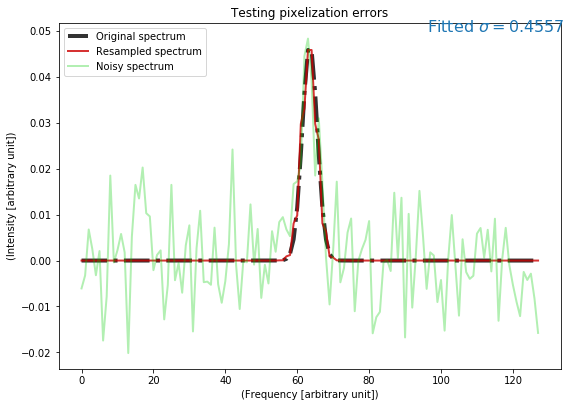

In [39]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
v_delta = 0.21  # km/s

i = 38
print 'Assuming cores are virialized \n \
--> core {} parameters: '.format(i) 
Reff = 1300./206265 * Dreff[i]   # pc
M = Mgas[i]      # Msolar
alpha = 2.0
sigma2fwhm = 2.*np.sqrt(2*np.log(2))

sigma = np.sqrt(alpha * M * G /(5.* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

print '-----------------------------------'

A = 0.04719
test_spectrum = gaussian_spectrum(name='test', A=A, sigma=sigma/v_delta, bins=128)

fig = plt.figure(figsize=(9, 14))
plt.subplot(2, 1, 1)

# plotting the original gaussian spectrum
plt.plot(test_spectrum.x , test_spectrum.data, \
         '-.',
         color = (0, 0, 0.0, 0.8),
         linewidth=4, label = 'Original spectrum')    

# resampling
test_spectrum.resample(pixelsize=2, pixelshift=7)
plt.plot(test_spectrum.x , test_spectrum.resampleddata, \
         color = (0.8, 0.0, 0.0, 0.8),
         linewidth=2, label = 'Resampled spectrum')    

# inject noise
test_spectrum.add_noise(RMS=0.008)
plt.plot(test_spectrum.x , test_spectrum.data, \
         color = (0, 0.8, 0.0, 0.3),
         linewidth=2, label = 'Noisy spectrum')    

# fit Gaussian and print the results
coeff = test_spectrum.refit_gaussian()
print( coeff )
plt.text( test_spectrum.bins*0.75, coeff[0]*1.1,
         'Fitted $\sigma=$%s' %(str( round( coeff[2], 2)*v_delta ) ), 
         {'color': 'C0', 'fontsize': 16})

spectrum_fit = gauss( test_spectrum.x, *coeff)
#plt.plot(test_spectrum.x, spectrum_fit, label='Fitted Gaussian')

plt.title('Testing pixelization errors')
plt.xlabel( '(Frequency [arbitrary unit])')
plt.ylabel( '(Intensity [arbitrary unit])')
plt.legend(loc=2)
#print 'Fitted $\sigma=$%s' %(str( round( coeff[2], 2) ) )

In [40]:
T[30]

index,newindex,peak,flux,pbflux,major,minor,pa,RA,DEC,r_eff,decr_eff,Mass,decmajor,decminor,decpa,erdecmaj,erdecmin,separation,RApix,DECpix,fitted_Asigma,fitted_Bsigma,fitted_Csigma,fitted_Dsigma,A_Mach,B_Mach,C_Mach,n_vol,A_Mass,A_Mvir,A_vir,A_sigma,A_decr,B_Mass,B_Mvir,B_vir,B_sigma,B_decr,C_Mass,C_Mvir,C_vir,C_sigma,C_decr,A_nvol,B_nvol,C_nvol,B_A,A_Pek,B_Pek,C_Pek,AOmega_P,AOmega_G,AOmega_K,AOmega_F,BOmega_P,BOmega_G,BOmega_K,BOmega_F,COmega_P,COmega_G,COmega_K,COmega_F
,,Jy beam$^{-1}$,Jy,Jy,arcsec,arcsec,deg,deg,deg,arcsec,arcsec,M$_{\odot}$,arcsec,arcsec,deg,arcsec,arcsec,pc,pix,pix,km / s,km / s,km / s,km / s,,,,cm$^{-3}$,M$_{\odot}$,M$_{\odot}$,,,pc,M$_{\odot}$,M$_{\odot}$,,,pc,M$_{\odot}$,M$_{\odot}$,,,pc,cm$^{-3}$,cm$^{-3}$,cm$^{-3}$,mG,K cm$^{-3}$,K cm$^{-3}$,K cm$^{-3}$,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg,erg
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
29,30,0.000316854381704133,0.0007903544132662207,0.0008071661243994486,4.940552818148991,4.3038208363020445,91.3269012806483,259.77400110072824,-36.10737731354143,2.7693136032283583,2.085316151924309,0.7192838466891971,3.691987779783042,3.2656452990716094,147.44459872304998,0.73,1.05,0.048989365333059684,612.0,847.9,0.3088,0.2066,nan,nan,1.2342,0.7446,nan,1457009.5141974983,0.6391492723780063,2.2331690276322225,3.493971008249039,0.38231,0.013142855052973608,0.08013457713436972,0.432818420608423,5.401144375949881,0.29152,0.004380951684324536,nan,nan,nan,nan,nan,1294685.7803687013,4382740.813377517,nan,nan,18678194.17582363,21076332.72756427,nan,-2.161529265900905e+42,-2.659041928306134e+42,2.787145600518962e+42,-2.2787393796954873e+41,-9.033530515862117e+40,-1.253954393708381e+41,2.0318081698955866e+41,-8.439775480353658e+39,nan,nan,nan,nan


Assuming cores are virialized 
 --> core 30 parameters: 
sigma 0.30684567864540213 km/s 
FWHM 0.7225663548053181 km/s 
Reff 0.013142855052973608 pc
-----------------------------------
[4.43245832e-02 6.33847234e+01 1.53884642e+00]


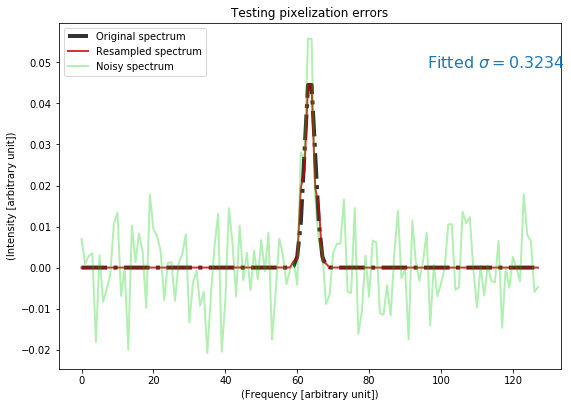

In [41]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
v_delta = 0.21  # km/s

i = 30
print 'Assuming cores are virialized \n \
--> core {} parameters: '.format(i) 
Reff = 1300./206265 * Dreff[i]   # pc
M = Mgas[i]      # Msolar
alpha = 2.0
sigma2fwhm = 2.*np.sqrt(2*np.log(2))

sigma = np.sqrt(alpha * M * G /(5.* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

print '-----------------------------------'

A = 0.04719
test_spectrum = gaussian_spectrum(name='test', A=A, sigma=sigma/v_delta, bins=128)

fig = plt.figure(figsize=(9, 14))
plt.subplot(2, 1, 1)

# plotting the original gaussian spectrum
plt.plot(test_spectrum.x , test_spectrum.data, \
         '-.',
         color = (0, 0, 0.0, 0.8),
         linewidth=4, label = 'Original spectrum')    

# resampling
test_spectrum.resample(pixelsize=2, pixelshift=7)
plt.plot(test_spectrum.x , test_spectrum.resampleddata, \
         color = (0.8, 0.0, 0.0, 0.8),
         linewidth=2, label = 'Resampled spectrum')    

# inject noise
test_spectrum.add_noise(RMS=0.008)
plt.plot(test_spectrum.x , test_spectrum.data, \
         color = (0, 0.8, 0.0, 0.3),
         linewidth=2, label = 'Noisy spectrum')    

# fit Gaussian and print the results
coeff = test_spectrum.refit_gaussian()
print( coeff )
plt.text( test_spectrum.bins*0.75, coeff[0]*1.1,
         'Fitted $\sigma=$%s' %(str( round( coeff[2], 2)*v_delta ) ), 
         {'color': 'C0', 'fontsize': 16})

spectrum_fit = gauss( test_spectrum.x, *coeff)
#plt.plot(test_spectrum.x, spectrum_fit, label='Fitted Gaussian')

plt.title('Testing pixelization errors')
plt.xlabel( '(Frequency [arbitrary unit])')
plt.ylabel( '(Intensity [arbitrary unit])')
plt.legend(loc=2)
#print 'Fitted $\sigma=$%s' %(str( round( coeff[2], 2) ) )

In [158]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
Reff = 1300./206265 * 1.31961   # pc
M = 0.27323      # Msolar
alpha = 2
sigma2fwhm = 2*np.sqrt(2*np.log(2))

sigma = np.sqrt(alpha * M * G /(5* Reff))
print 'sigma',sigma, 'km/s','\n',\
'FWHM',sigma * sigma2fwhm, 'km/s','\n',\
'Reff',Reff, 'pc'

sigma 0.23773723285703255 km/s 
FWHM 0.5598284013819307 km/s 
Reff 0.00831693695004 pc


In [159]:
G = 4.301e-3  # pc * Msolar^-1 * (km/s)^2
Reff = 1000./206265#1300./206265 * 1.31961   # pc
M = 0.1#0.27323      # Msolar
alpha = 2

sigma = np.sqrt(alpha * M * G /(5* Reff))
print sigma, 'km/s','\n', Reff, 'pc'

0.18837683137795902 km/s 
0.00484813225705 pc
